In [12]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [1]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

In [2]:
# Use small bs as we have very limited data due to conditional hierarchy filtering
dls, labels = util.chexpert_data_loader(use_hierarchy=True, bs=4)

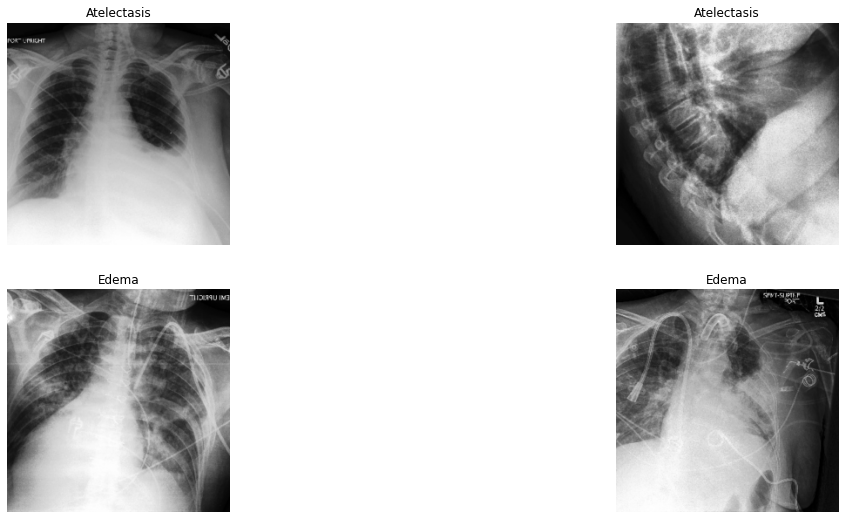

In [3]:
dls.show_batch(max_n=9, figsize=(20,9))

In [4]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/user/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


lr_min/10: 2.7542287170945203e-07, lr_steep: 1.5848931980144698e-06, base_lr: 1.5848931980144698e-06


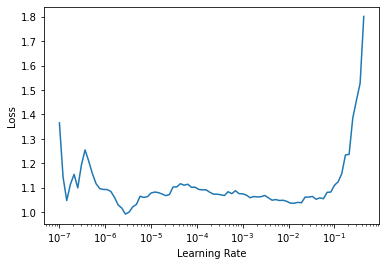

In [5]:
chexpert_learner_conditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,1.116807,0.897930,[0.47038086 0.52775078 0.45024439 0.46169581],0.486201,01:13


Better model found at epoch 0 with valid_loss value: 0.8979299664497375.


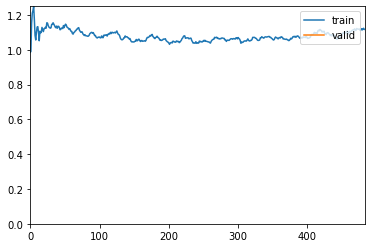

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.980769,0.879257,[0.47000694 0.53267963 0.45378494 0.45631947],0.486727,01:20
1,1.070762,0.880267,[0.47326532 0.55994446 0.45995739 0.45284385],0.497158,01:22
2,1.067583,0.904258,[0.45667966 0.56459563 0.46641183 0.44636327],0.494898,01:22
3,1.043202,0.869740,[0.45472998 0.53859771 0.46127334 0.4482278 ],0.484780,01:20
4,1.048243,0.873872,[0.45448961 0.53554321 0.43545557 0.45881757],0.483481,01:21
5,1.085431,0.864643,[0.45518402 0.56702534 0.45416092 0.46135187],0.498706,01:23
6,1.036180,0.858048,[0.4695262 0.56135023 0.46609851 0.45144998],0.497445,01:24
7,1.020663,0.854981,[0.45940388 0.5607428 0.44165936 0.4507259 ],0.491938,01:23
8,1.026694,0.864148,[0.47657711 0.57530371 0.45365961 0.44582021],0.500312,01:20
9,0.994895,0.854465,[0.47705785 0.57119056 0.47944605 0.4532964 ],0.504801,01:20


Better model found at epoch 0 with valid_loss value: 0.8792567253112793.


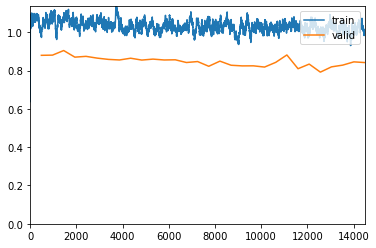

Epoch 2: reducing lr to 3.1678027302674974e-08
Better model found at epoch 3 with valid_loss value: 0.8697401881217957.
Better model found at epoch 5 with valid_loss value: 0.864643394947052.
Better model found at epoch 6 with valid_loss value: 0.8580476641654968.
Better model found at epoch 7 with valid_loss value: 0.8549808263778687.
Better model found at epoch 9 with valid_loss value: 0.8544647097587585.
Epoch 11: reducing lr to 7.532617894661364e-08
Better model found at epoch 13 with valid_loss value: 0.8417269587516785.
Better model found at epoch 15 with valid_loss value: 0.8220599293708801.
Epoch 17: reducing lr to 4.845139885629323e-08
Epoch 19: reducing lr to 3.667400926170358e-08
Better model found at epoch 20 with valid_loss value: 0.8179702758789062.
Epoch 22: reducing lr to 1.982239206079771e-08
Better model found at epoch 23 with valid_loss value: 0.8093379139900208.
Better model found at epoch 25 with valid_loss value: 0.791519284248352.
Epoch 27: reducing lr to 1.76470

In [6]:
chexpert_learner_conditional.learn_model(use_saved=False, epochs=30)

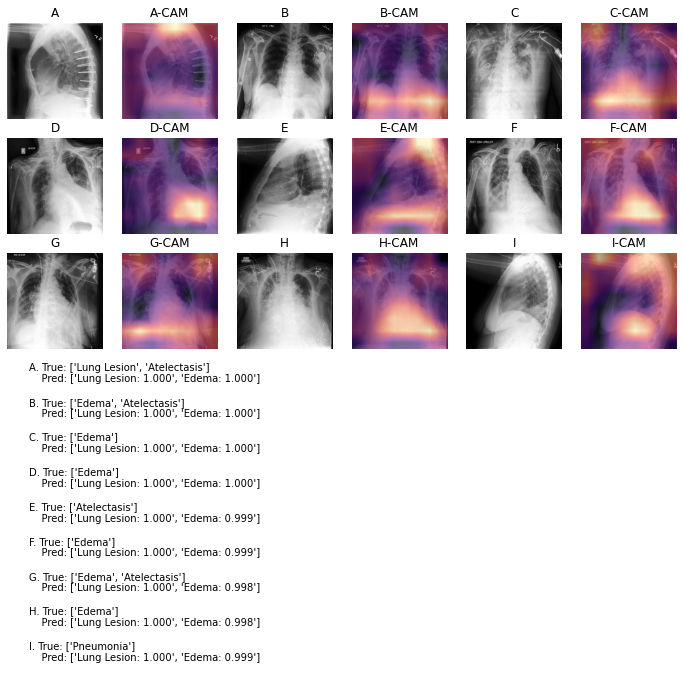

In [7]:
# Let us see how the conditional model predicts - use the saved optimal model
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [8]:
# Reload the data as it may have been modified for conditional probs
dls, labels = util.chexpert_data_loader()

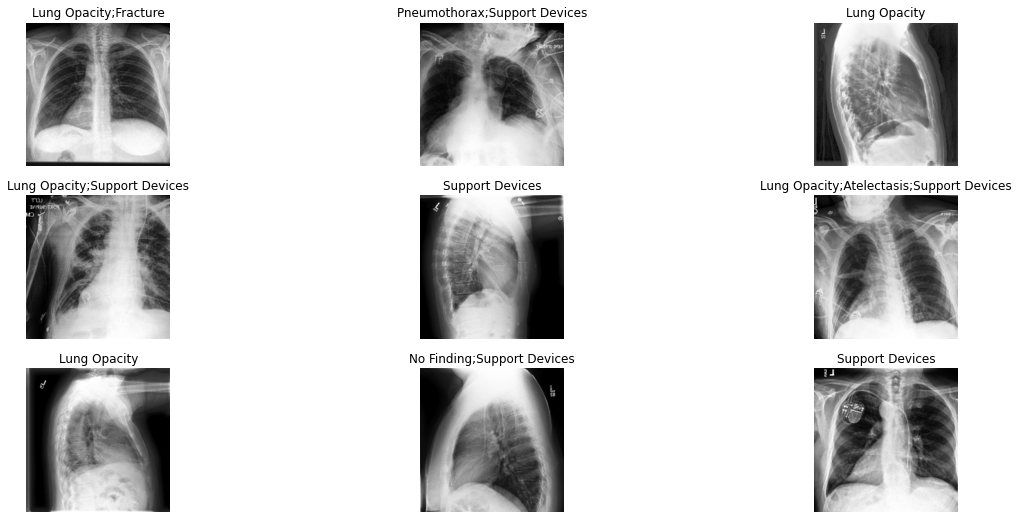

In [9]:
dls.show_batch(max_n=9, figsize=(20,9))

In [10]:
# Next train unconditionally for only transfer learning
chexpert_learner_unconditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.025118863582611083, lr_steep: 0.033113110810518265, base_lr: 0.033113110810518265


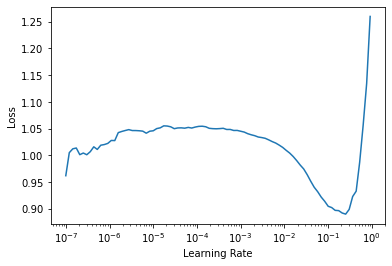

In [11]:
chexpert_learner_unconditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.306174,0.293807,[0.86016109 0.62813033 0.80376793 0.71035265 0.72867389 0.83105113 0.68858283 0.70370313 0.66873392 0.8033946 0.8534123 0.76344527 0.6904841 0.83520385],0.784272,16:51
1,0.294432,0.286416,[0.86822326 0.65712435 0.83122965 0.71976453 0.7385258 0.83749268 0.70506682 0.72831729 0.67863783 0.83035834 0.8645626 0.77898897 0.71407014 0.85528785],0.798757,16:59
2,0.292309,0.283534,[0.86999254 0.66250697 0.8386324 0.72429431 0.74799868 0.84187606 0.71211145 0.73280544 0.68507895 0.84298815 0.86916693 0.79055982 0.72709644 0.86204485],0.804621,16:55
3,0.292287,0.282242,[0.87083888 0.65278011 0.84144175 0.72177377 0.72919698 0.84352381 0.71882752 0.73159464 0.68755336 0.84933935 0.87067847 0.7772897 0.70952789 0.86853765],0.805813,16:48
4,0.289620,0.281493,[0.87144418 0.65531262 0.84383102 0.7220582 0.75607567 0.84330624 0.7212481 0.74413164 0.6860541 0.85577985 0.87382506 0.79351773 0.73570204 0.87047664],0.808409,16:54
5,0.287576,0.283264,[0.86869323 0.65546098 0.84605848 0.72023508 0.74926802 0.84367028 0.72034257 0.74254076 0.68883238 0.84907754 0.87174187 0.78477662 0.71921372 0.87366491],0.807860,16:47
6,0.292557,0.284304,[0.8728341 0.65047634 0.84635525 0.72387018 0.74443509 0.84134884 0.70117688 0.72402403 0.68234841 0.85747064 0.87172603 0.78905542 0.72010273 0.87292809],0.807369,16:50
7,0.290646,0.284966,[0.8699211 0.65701777 0.84631259 0.72008614 0.74782435 0.84180505 0.71071139 0.72843652 0.68462503 0.84951609 0.87285022 0.77684819 0.71819527 0.87371774],0.807140,16:49


Better model found at epoch 0 with valid_loss value: 0.29380664229393005.


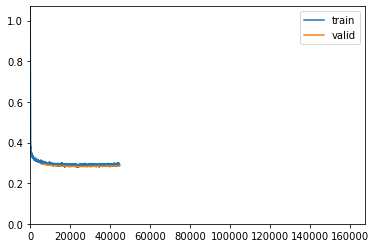

Better model found at epoch 1 with valid_loss value: 0.28641560673713684.
Better model found at epoch 2 with valid_loss value: 0.28353431820869446.
Better model found at epoch 3 with valid_loss value: 0.28224170207977295.
Better model found at epoch 4 with valid_loss value: 0.2814926505088806.
Epoch 6: reducing lr to 0.0005485924913809341


KeyboardInterrupt: 

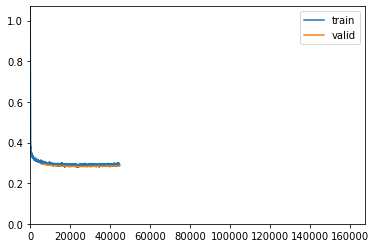

<IPython.core.display.Javascript object>

In [18]:
%%notify

# Freeze the body and update the weights for the last layer
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, old_learner=chexpert_learner_conditional.learn, epochs=0, freeze_epochs=30)

In [19]:
%%notify

# Unfreeze the body and update the whole model end-to-end
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=30, freeze_epochs=0)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

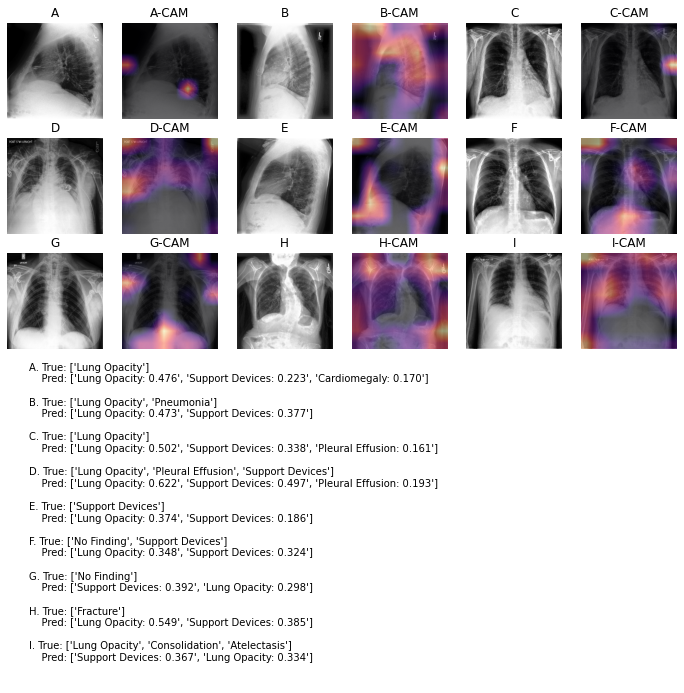

In [20]:
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [21]:
s

NameError: name 's' is not defined